In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [ ]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *

### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
lat_min = 32
lat_max = 44

datadir="/dmidata/users/maxb/NATL_dataset"
datamodule = BaseDataModule(input_da=load_altimetry_data(datadir+"/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 16, 'num_workers': 1},
                            grad=False,
                            #aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Observational cost and Prior cost

In [ ]:
class BaseObsCost(nn.Module):
    def __init__(self, w=1) -> None:
        super().__init__()
        self.w=w

    def forward(self, state, batch):
        msk = batch.input.isfinite()
        return self.w * F.mse_loss(state[msk], batch.input.nan_to_num()[msk])

class BilinAEPriorCost(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, downsamp=None, bilin_quad=True, nt=None):
        super().__init__()
        self.nt = nt
        self.bilin_quad = bilin_quad
        self.conv_in = nn.Conv2d(
            dim_in, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.conv_hidden = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.bilin_1 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_21 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )
        self.bilin_22 = nn.Conv2d(
            dim_hidden, dim_hidden, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.conv_out = nn.Conv2d(
            2 * dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def forward_ae(self, x):
        x = self.down(x)
        x = self.conv_in(x)
        x = self.conv_hidden(F.relu(x))

        nonlin = self.bilin_21(x)**2 if self.bilin_quad else (self.bilin_21(x) * self.bilin_22(x))
        x = self.conv_out(
            torch.cat([self.bilin_1(x), nonlin], dim=1)
        )
        x = self.up(x)
        return x

    def forward(self, state, exclude_params=False):
        if not exclude_params:
            return F.mse_loss(state, self.forward_ae(state))
        else:
            return F.mse_loss(state[:,:self.nt,:,:], self.forward_ae(state)[:,:self.nt,:,:])

# Define the solver (Diff)

In [4]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    ret = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    return ret

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class GradNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self,
               time_channels = 9,
               channels=[32, 64, 128, 256], 
               embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    #self.conv1 = nn.Conv2d(time_channels, channels[0], 3, stride=1, padding=1, bias=False)
    self.conv1 = nn.Conv2d(2*time_channels, channels[0], 3, stride=1, padding=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(int(np.floor(channels[0]/8)), num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(channels[0], num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(channels[0], num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(channels[0], num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(channels[0], num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(channels[0], num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, padding=1, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(channels[0], num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], time_channels, 3, stride=1, padding=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    
    self.norm = torch.nn.Parameter(torch.tensor([1.]))
  
  # !! add y to try stacked conditioning
  def forward(self, x, y, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    h1 = self.conv1(torch.cat([x,y],dim=1))
    #h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    #h = h / self.marginal_prob_std(t)[:, None, None, None]
        
    return h

In [5]:
class GradSolver_Diff(nn.Module):
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2, reset_state=True, **kwargs):
        super().__init__()
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod

        self.n_step = n_step
        self.lr_grad = lr_grad

        self._grad_norm = None
        self.reset_state = reset_state
        self.lambda_reg = torch.nn.Parameter(torch.ones((1)))
        
    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init
        return torch.randn(batch.tgt.size(),device=device).detach().requires_grad_(True)

    def solver_step(self, state, batch, step):
        var_cost = self.lambda_reg*self.prior_cost(state) + self.obs_cost(state, batch)
        #grad = torch.autograd.grad(var_cost, state, 
        #                           create_graph=True)[0]

        #gmod = self.grad_mod(grad, batch.input, step)
        gmod = self.grad_mod(state, batch.input, step)
        state_update = gmod
        return state - state_update, None#grad

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            #if self.reset_state:
            #    self.grad_mod.reset_state(batch.input)

            all_steps = []
            for step in range(self.n_step):
                state, _ = self.solver_step(state, batch,
                                            step=torch.tensor(step).repeat(batch.tgt.size()[0]).to(device))
                if not self.training:
                    state = state.detach().requires_grad_(True)
                all_steps.append(state.detach())

            #if not self.training:
            #    state = self.prior_cost.forward_ae(state)
            #state = self.prior_cost.forward_ae(state)
        return state, all_steps

In [6]:
device = 'cuda'

# state only
solver = GradSolver_Diff(n_step=15,
                    lr_grad=1e-3,
                    prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                    obs_cost = BaseObsCost(),
                    grad_mod = GradNet()).to(device)

# Diffusion training

In [7]:
import functools

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The sigma in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
    
def loss_fn(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  fixed_t = torch.linspace(1-eps, eps, solver.n_step)
  random_t = fixed_t[torch.randint(len(fixed_t),(x.shape[0],))].to(x.device)
    
  # random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x).to(device)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, y, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

sigma =  25.0#@param {'type':'number'}
#sigma = 5.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 50, 'lon': 50}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

n_epochs =  3000#@param {'type':'integer'}
lr = 2e-4 #@param {'type':'number'}
    
optimizer = torch.optim.Adam(
        [
            {"params": solver.parameters(), "lr": lr},
        ])

def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

reload = True
if reload:
    ckpt = torch.load('../ckpt/ckpt_4diff2.pth', map_location=device)
    solver.load_state_dict(ckpt)

tqdm_epoch = tqdm(range(n_epochs))
solver.training = True
for epoch in tqdm_epoch:
  print(epoch)
  for batch in data_loader:
    batch = batch._replace(input=(batch.input).nan_to_num().to(device))
    batch = batch._replace(tgt=(batch.tgt).to(device))
    out, all_steps = solver(batch)
    loss = weighted_mse(out - batch.tgt, optim_weight)
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    prior_cost = solver.prior_cost(solver.init_state(batch, out))
    loss = 50*loss  + 10000 * grad_loss + 10 * prior_cost 
    #loss = loss_fn(solver.grad_mod, batch.tgt, batch.input, marginal_prob_std_fn)
    optimizer.zero_grad()
    if loss is not None:
        loss.backward()
    optimizer.step()
    print(loss)

    
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../ckpt/ckpt_4diff2.pth')

# Test of the model

/tmp/ipykernel_2781782/2140229816.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('../ckpt/ckpt_4diff2.pth', map_location=device)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


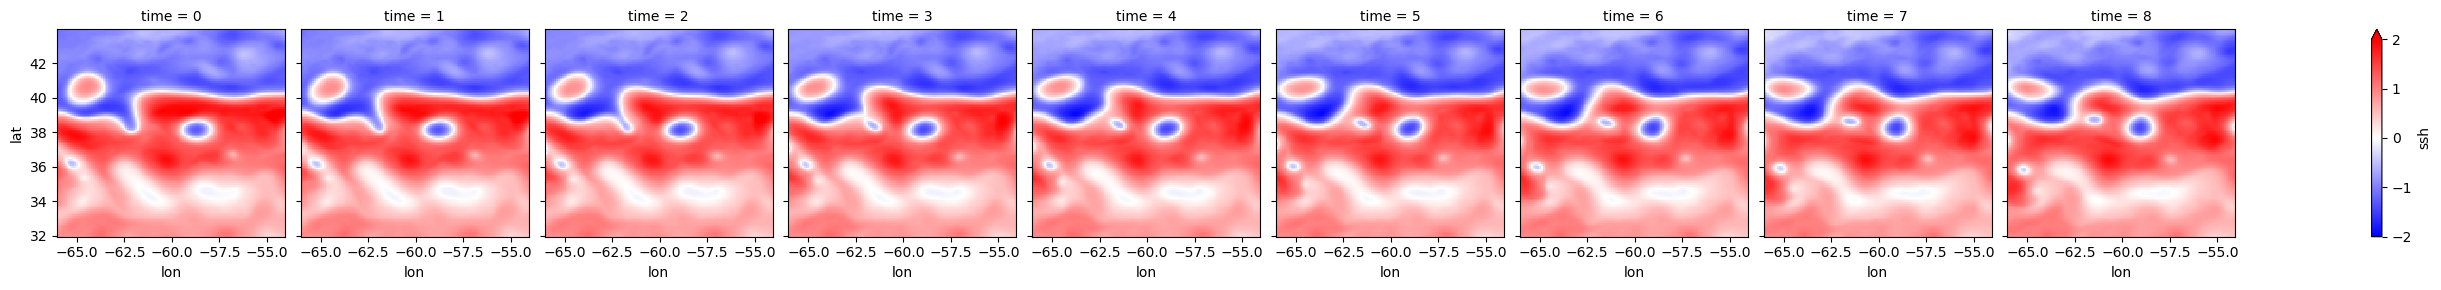

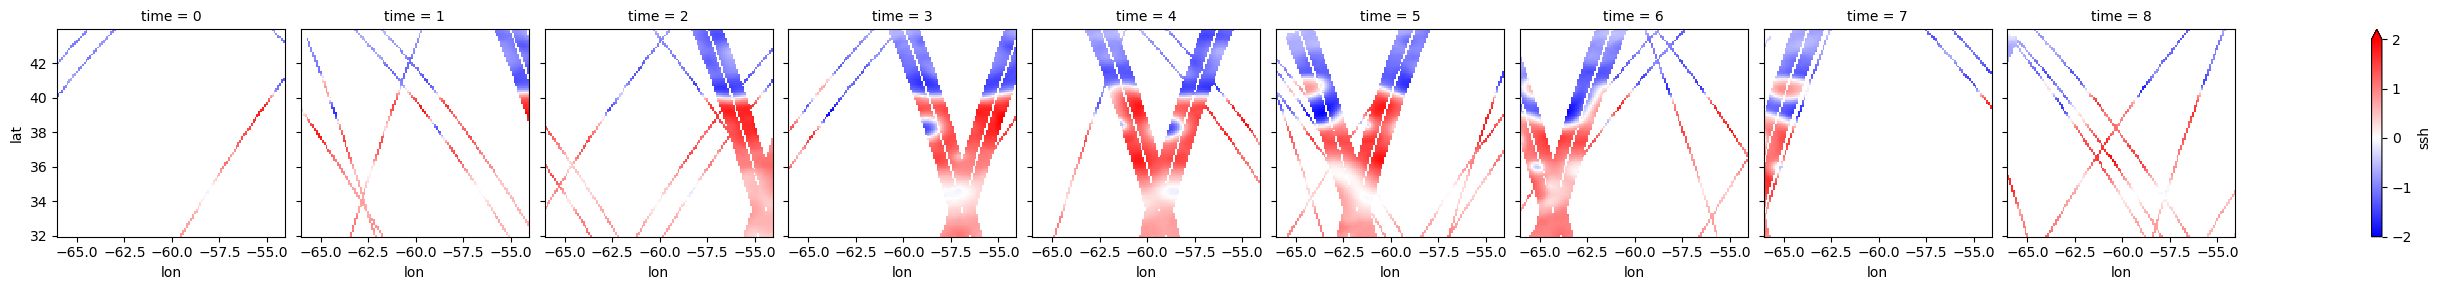

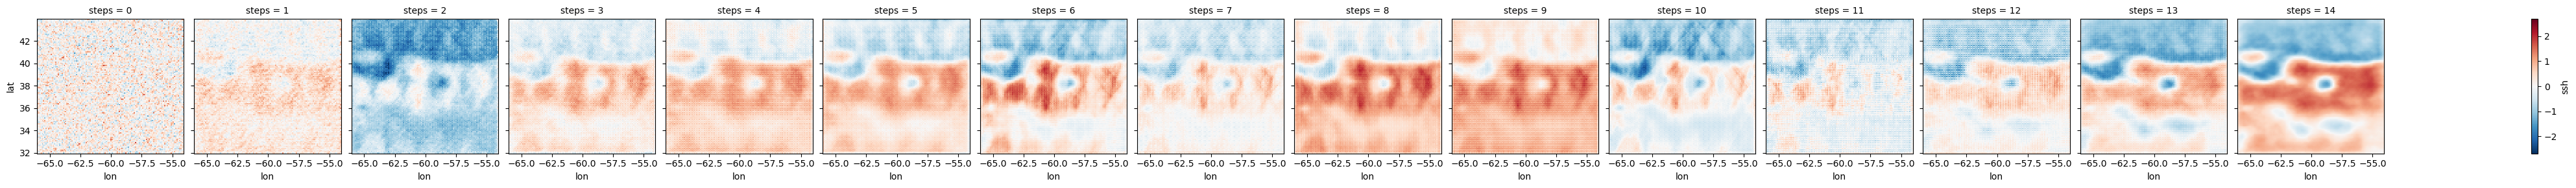

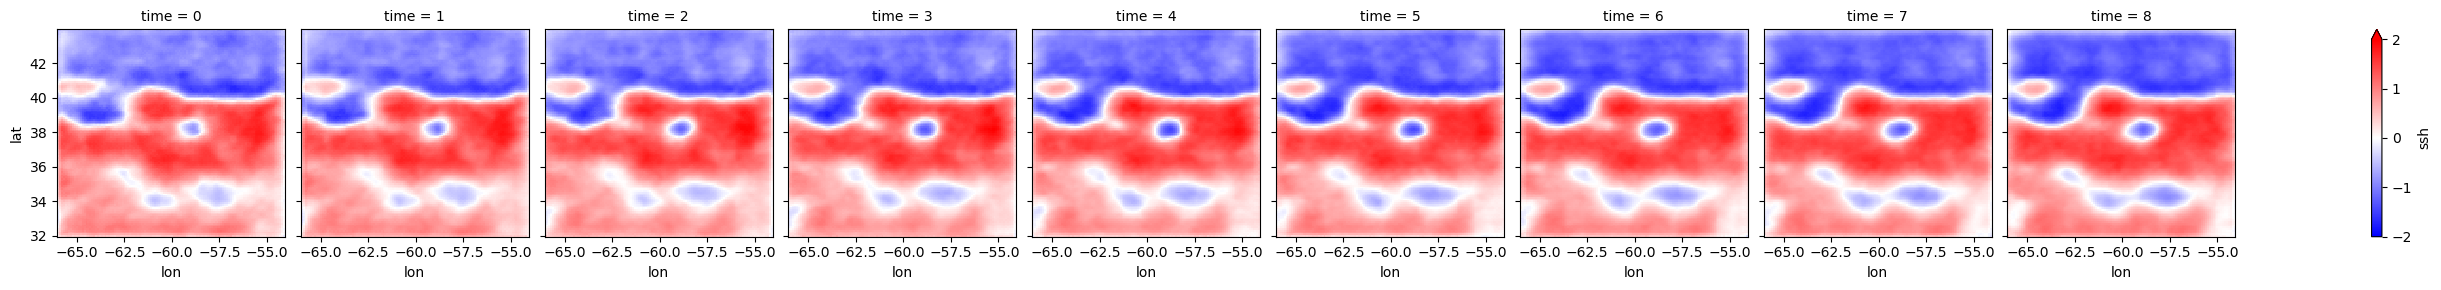

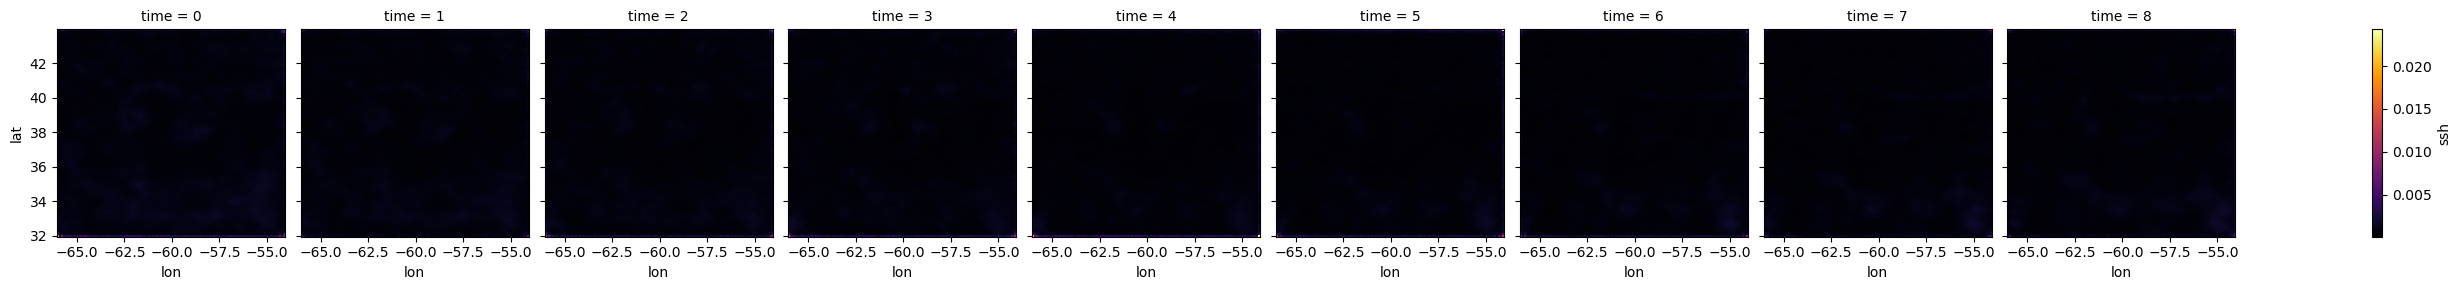

In [18]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_4diff2.pth', map_location=device)
solver.load_state_dict(ckpt)

from kornia.filters import sobel

k = 1
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.input[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)

test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out, all_steps = solver(test_batch)
all_steps = torch.stack(all_steps,dim=1)
xr.Dataset(data_vars={'ssh':(('steps','lat','lon'),all_steps[5,:,4,:,:].detach().cpu())},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='steps',col_wrap=15)

out = []
for i in range(20):
    print(i)
    out.append(solver(test_batch)[0].detach())
    

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[0][5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[5,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',cmap=plt.cm.inferno)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


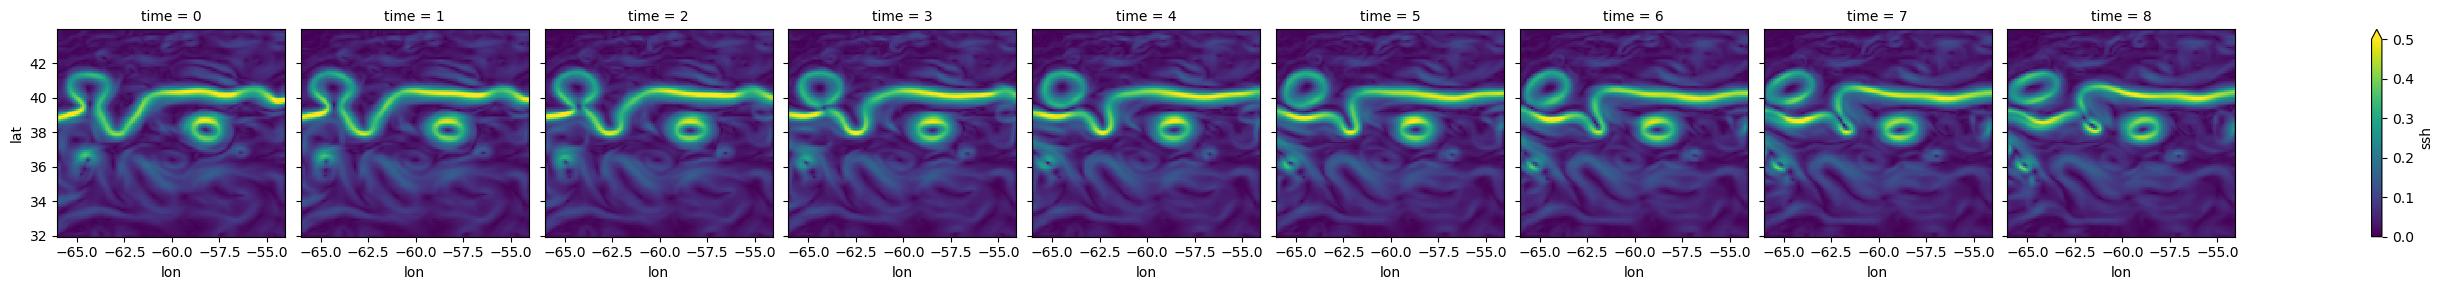

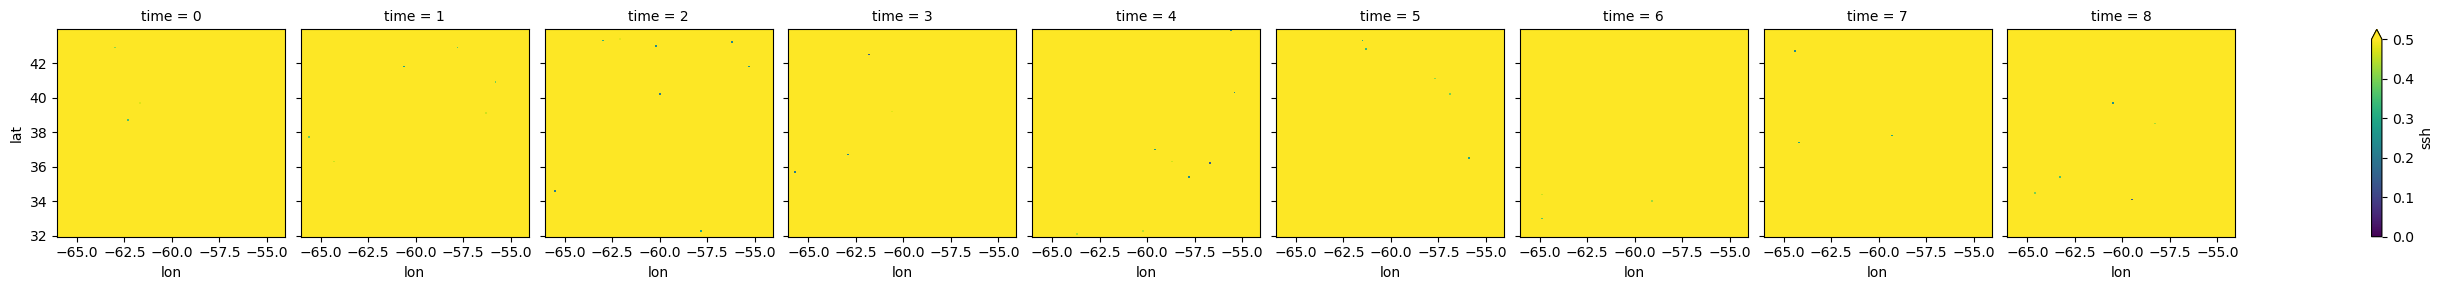

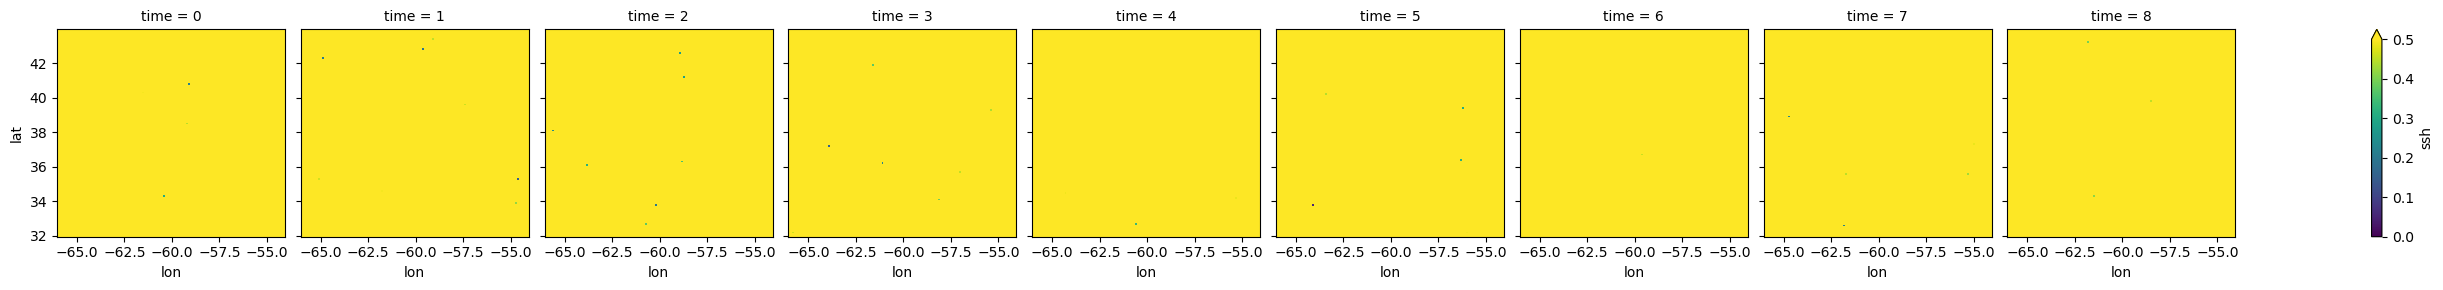

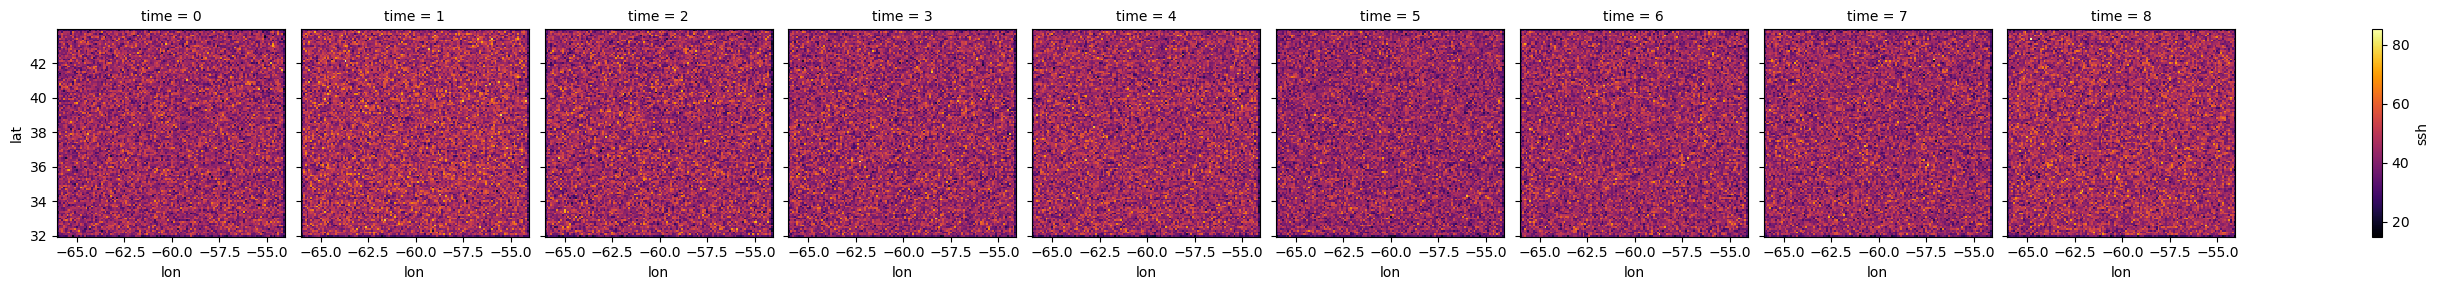

In [63]:
# test
from IPython.display import clear_output
#ckpt = torch.load('../ckpt/ckpt_4diff.pth', map_location=device)
#solver.load_state_dict(ckpt)

from kornia.filters import sobel

k = 1
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))
test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

def sample(batch):
    state = torch.randn_like(batch.tgt).to(device) #* marginal_prob_std(torch.ones(batch.tgt.shape[0], device=device),sigma=25)[:, None, None, None] 
    state = state.requires_grad_(True)
    for step in range(solver.n_step):
        state, _ = solver.solver_step(state, batch, step=torch.tensor((step,)).to(state.device))
        state = state.detach()
    return state

def sample(batch):
    state = torch.randn_like(batch.tgt).to(device) #* marginal_prob_std(torch.ones(batch.tgt.shape[0], device=device),sigma=25)[:, None, None, None] 
    state = state.requires_grad_(True)
    for step in range(solver.n_step):
        state, _ = solver.solver_step(state, batch, step=torch.tensor((step,)).to(state.device))
        state = state.detach()
    return state
    

out = []
for i in range(20):
    print(i)
    out.append(sample(test_batch))

xr.Dataset(data_vars={'ssh':(('time','lat','lon'),sobel(test_batch.tgt)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),sobel(out[0])[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),sobel(out[1])[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=0,vmax=0.5)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',cmap=plt.cm.inferno)

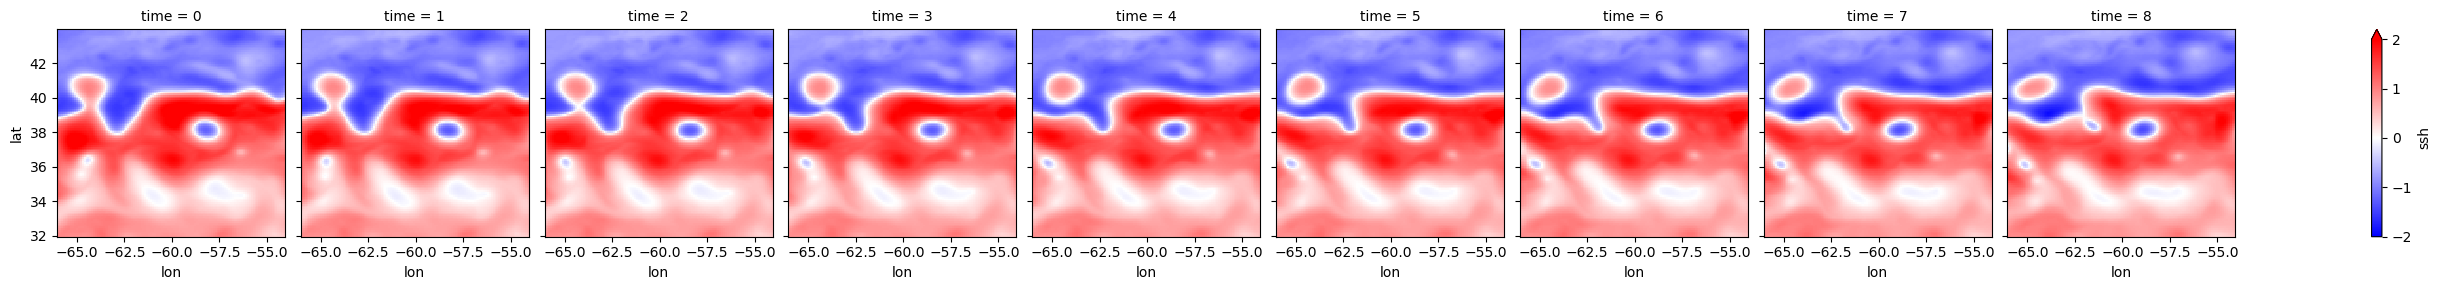

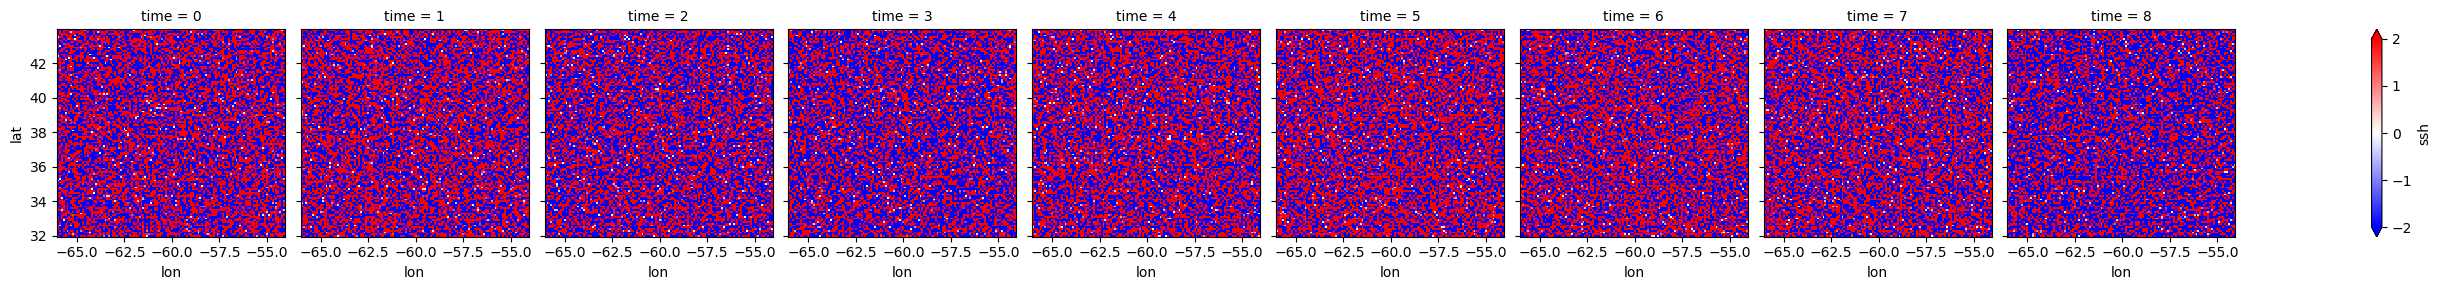

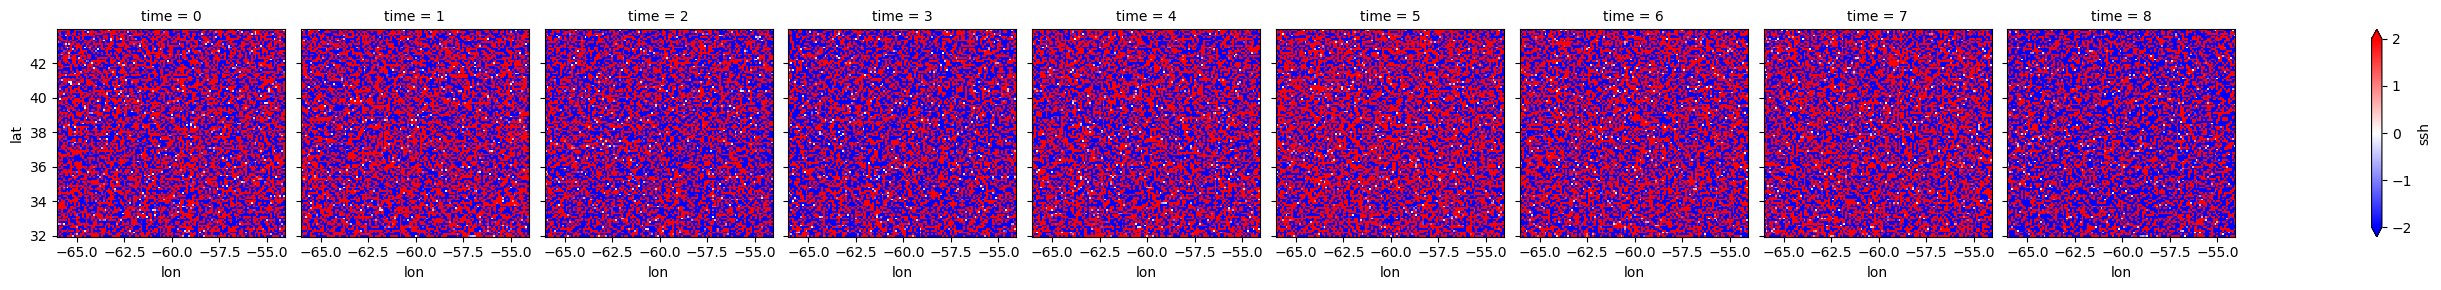

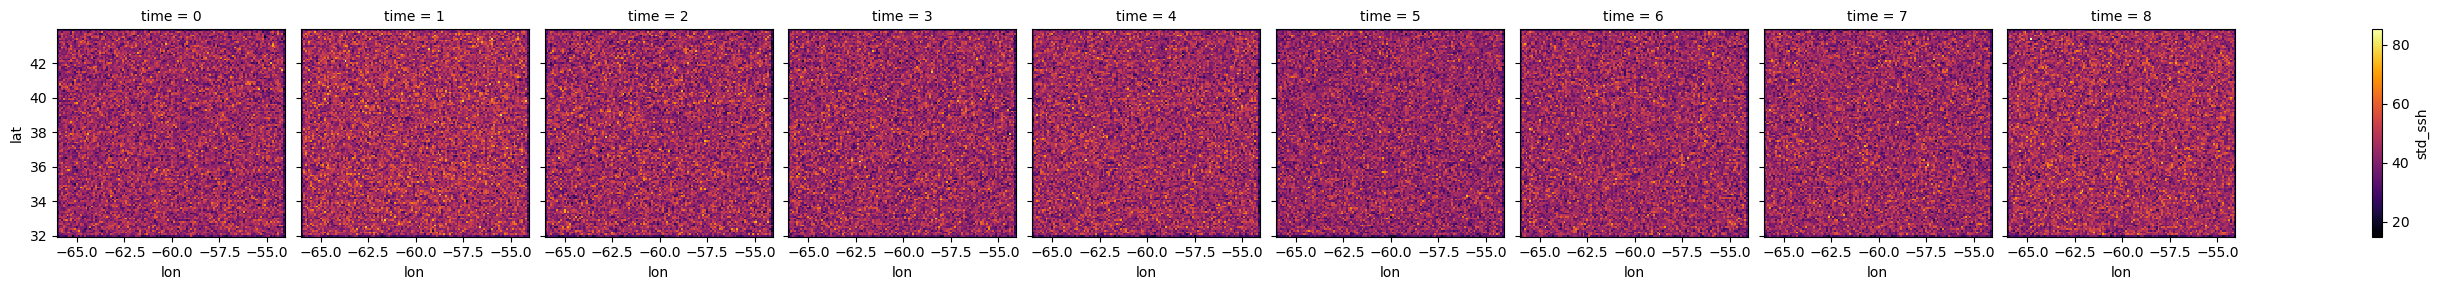

In [64]:
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[0][0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[1][0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',vmin=-2,vmax=2,cmap=plt.cm.bwr)
xr.Dataset(data_vars={'std_ssh':(('time','lat','lon'),torch.std(torch.stack(out,dim=0),dim=0)[0,:,:,:].detach().cpu())},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).std_ssh.plot(col='time',cmap=plt.cm.inferno)